In [1]:
import os
import sys
import numpy as np
import pandas as pd
import torch

sys.path.append(os.path.abspath(".."))

from models.lstm import (create_model, create_sequences, evaluate_model,
                         train_model)
from utils.plotting import plot_train_val, plot_train_val_losses, plot_usage
from utils.preprocess import (add_spotprice, add_time_based_features,
                              add_weather_forecast, interpolate_missing_hours,
                              split_train_val)

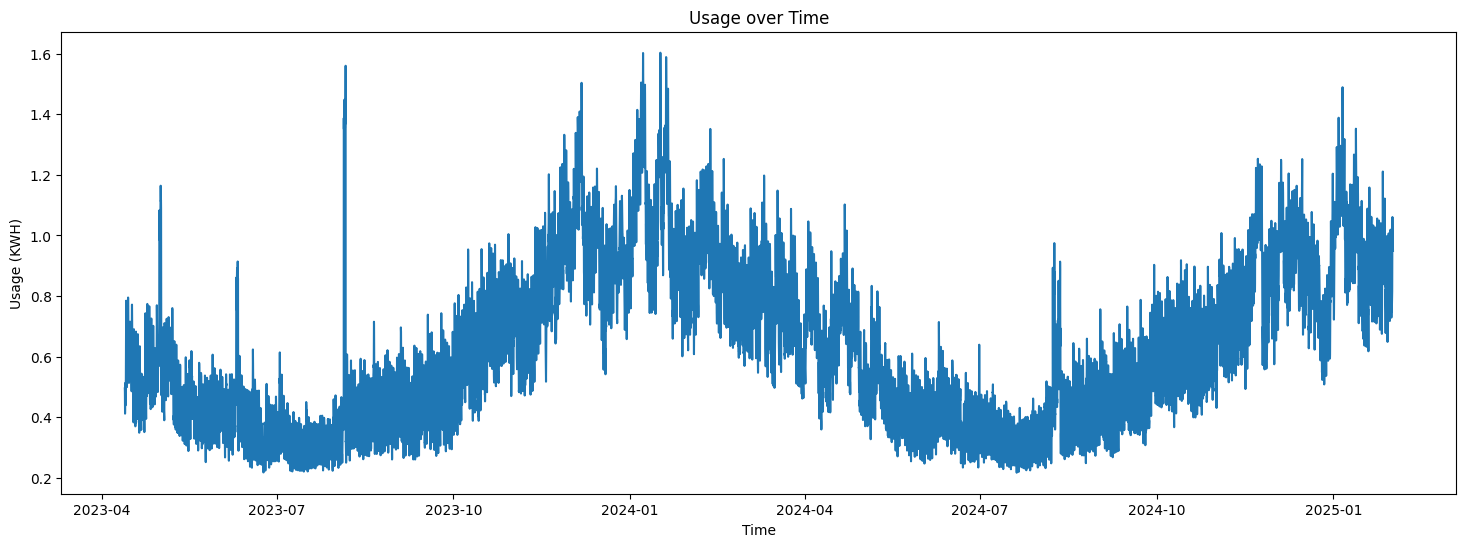

In [2]:
df_raw = pd.read_csv('../data/cons_sthlm_mean.csv')
df = interpolate_missing_hours(df_raw)
df = add_time_based_features(df)

spot_price_path = '../data/spotprices.csv'
se_area = 'SE3'
df = add_spotprice(df, spot_price_path, se_area)

weather_path = '../data/open-meteo-stockholm.csv'
#columns_to_add = ['temperature_2m']
columns_to_add = ['temperature_2m', 'precipitation', 'direct_radiation', 'uv_index', 'wind_speed_10m']
df = add_weather_forecast(df, weather_path, columns_to_add)

plot_usage(df)

In [3]:
df

,USAGE_AT,MONTH,DAY_OF_MONTH,WEEKDAY,HOUR,SPOTPRICE_SEK_BY_KWH,temperature_2m,precipitation,direct_radiation,uv_index,wind_speed_10m,USAGE_KWH
0,2023-04-13 00:00:00+00:00,4,13,3,0,0.01136,7.9,0.0,0.0,0.0,15.8,0.495219
1,2023-04-13 01:00:00+00:00,4,13,3,1,0.01009,7.5,0.0,0.0,0.0,16.2,0.484958
2,2023-04-13 02:00:00+00:00,4,13,3,2,0.01122,7.7,0.0,0.0,0.0,11.2,0.432565
3,2023-04-13 03:00:00+00:00,4,13,3,3,0.05652,7.9,0.0,0.0,0.0,16.2,0.411980
4,2023-04-13 04:00:00+00:00,4,13,3,4,0.35948,8.0,0.0,0.0,0.0,23.4,0.428065
...,...,...,...,...,...,...,...,...,...,...,...,...
15836,2025-01-31 20:00:00+00:00,1,31,4,20,0.88248,0.7,0.0,0.0,0.0,13.3,0.987562
15837,2025-01-31 21:00:00+00:00,1,31,4,21,0.86239,0.3,0.0,0.0,0.0,14.4,0.995537
15838,2025-01-31 22:00:00+00:00,1,31,4,22,0.51394,-0.0,0.0,0.0,0.0,14.4,0.984366
15839,2025-01-31 23:00:00+00:00,1,31,4,23,0.37785,-0.2,0.0,0.0,0.0,14.8,0.967191


In [4]:
columns = df.columns.tolist()

columns

['USAGE_AT',
 'MONTH',
 'DAY_OF_MONTH',
 'WEEKDAY',
 'HOUR',
 'SPOTPRICE_SEK_BY_KWH',
 'temperature_2m',
 'precipitation',
 'direct_radiation',
 'uv_index',
 'wind_speed_10m',
 'USAGE_KWH']

In [5]:
# NOTE: Variables for Sequence generation, splitting, and scaling

sequence_length = 24
window = 24

train_split = 0.9
scaler_type = 'minmax'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

X, y = create_sequences(df, columns, sequence_length, window)

Using device: cpu


In [6]:
X_train, y_train, X_val, y_val, scaler_x, scaler_y = split_train_val(X, y, train_split, scaler_type, device)

Applying minmax scaling.
X_train shape: torch.Size([14213, 24, 11])
y_train shape: torch.Size([14213, 1])
X_val shape: torch.Size([1580, 24, 11])
y_val shape: torch.Size([1580, 1])


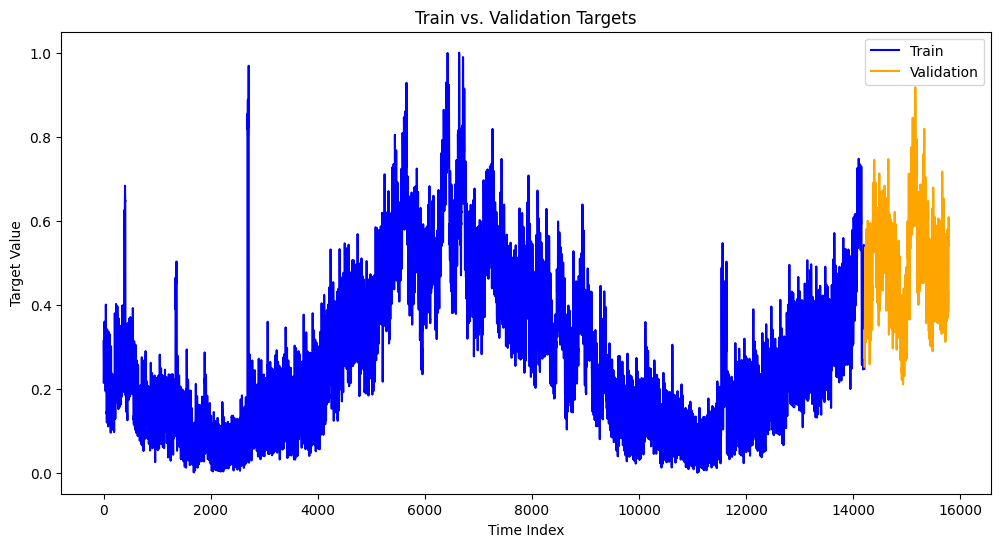

In [7]:
plot_train_val(y_train, y_val)

In [8]:
# NOTE: Model variables
input_dim = X_train.shape[2]
hidden_dim = 50
num_layers = 2
output_dim = 1

model = create_model(input_dim, hidden_dim, num_layers, output_dim, device)

model

LSTMModel(
  (lstm): LSTM(11, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [9]:
lr=0.01
gamma=0.9
noise_std=0.01
num_epochs=100

train_losses, val_losses, model = train_model(
        model, X_train, y_train, X_val, y_val,
        num_epochs, lr, gamma, noise_std
)

Applying Adaptive LR Scheduler: Step Size = 20 epochs, Decay Factor = 0.9
Applying gaussian noise: std = 0.01
Epoch 1/100, Train Loss: 0.1240, Val Loss: 0.1177
Epoch 2/100, Train Loss: 0.0420, Val Loss: 0.0184
Epoch 3/100, Train Loss: 0.0583, Val Loss: 0.0486
Epoch 4/100, Train Loss: 0.0322, Val Loss: 0.0841
Epoch 5/100, Train Loss: 0.0330, Val Loss: 0.1022
Epoch 6/100, Train Loss: 0.0370, Val Loss: 0.1038
Epoch 7/100, Train Loss: 0.0374, Val Loss: 0.0945
Epoch 8/100, Train Loss: 0.0347, Val Loss: 0.0785
Epoch 9/100, Train Loss: 0.0309, Val Loss: 0.0591
Epoch 10/100, Train Loss: 0.0278, Val Loss: 0.0400
Epoch 11/100, Train Loss: 0.0273, Val Loss: 0.0271
Epoch 12/100, Train Loss: 0.0291, Val Loss: 0.0236
Epoch 13/100, Train Loss: 0.0282, Val Loss: 0.0270
Epoch 14/100, Train Loss: 0.0242, Val Loss: 0.0342
Epoch 15/100, Train Loss: 0.0208, Val Loss: 0.0418
Epoch 16/100, Train Loss: 0.0195, Val Loss: 0.0421
Epoch 17/100, Train Loss: 0.0182, Val Loss: 0.0265
Epoch 18/100, Train Loss: 0.0134

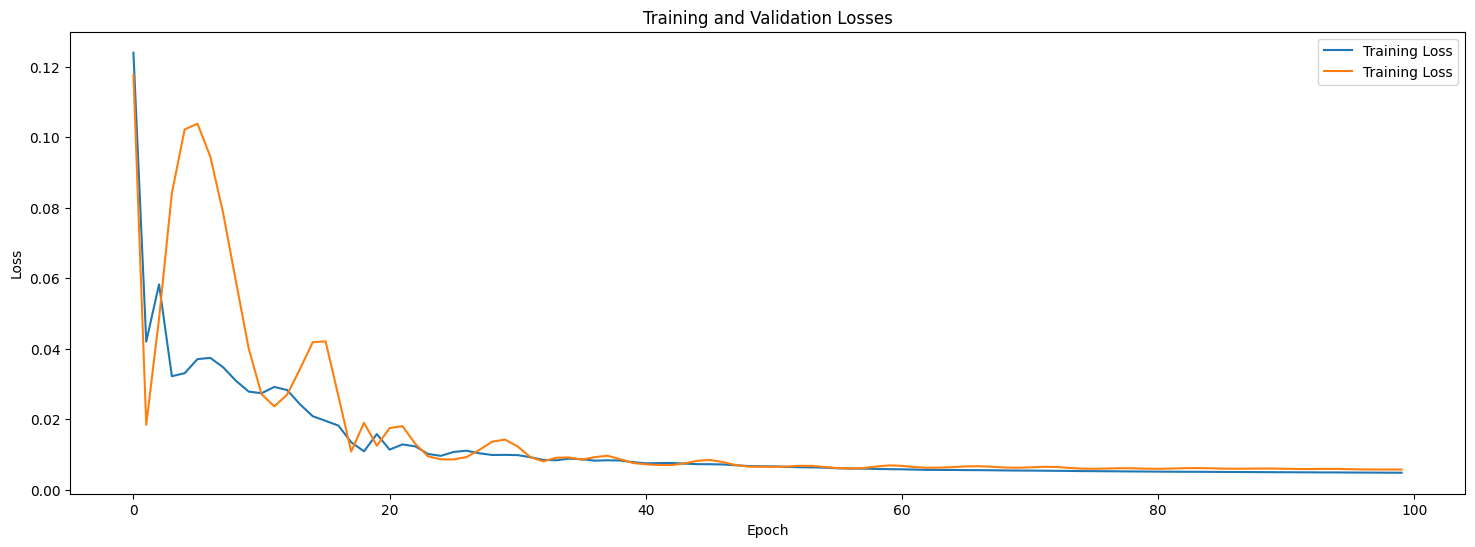

In [10]:
plot_train_val_losses(train_losses, val_losses)

MAE: 0.0823
MAPE: 9.20%
RMSE: 0.1047
kWh actual: 1418.8514404296875, kWh pred: 1388.508056640625, diff (%): 2.1385879516601562


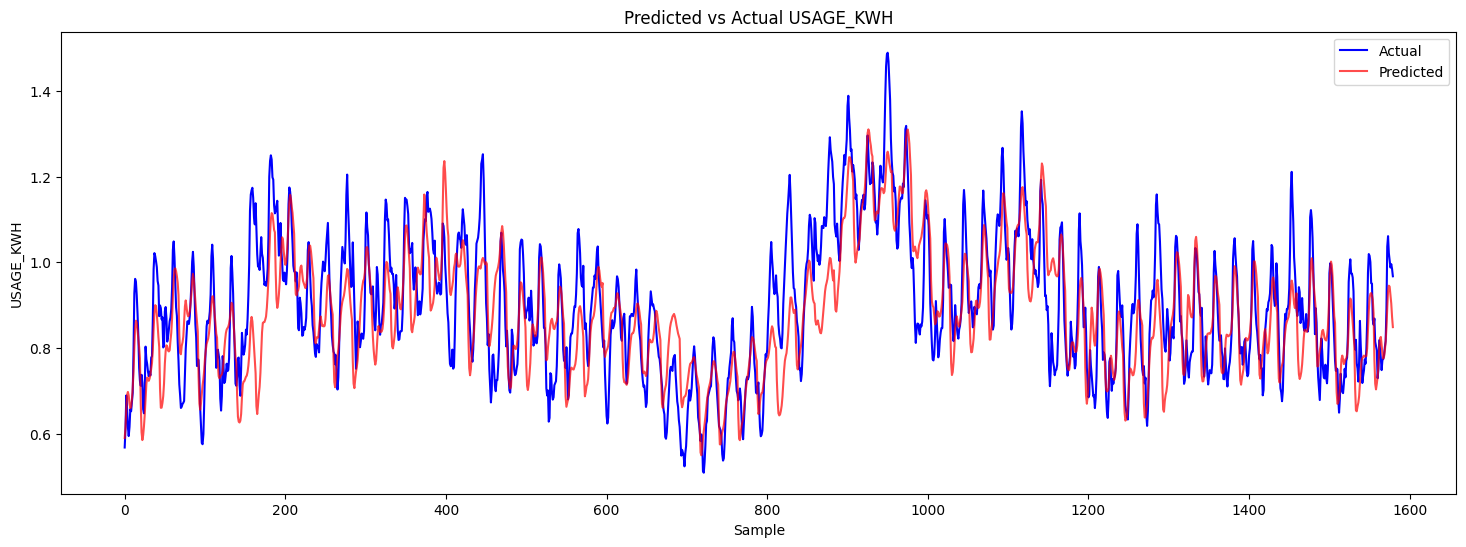

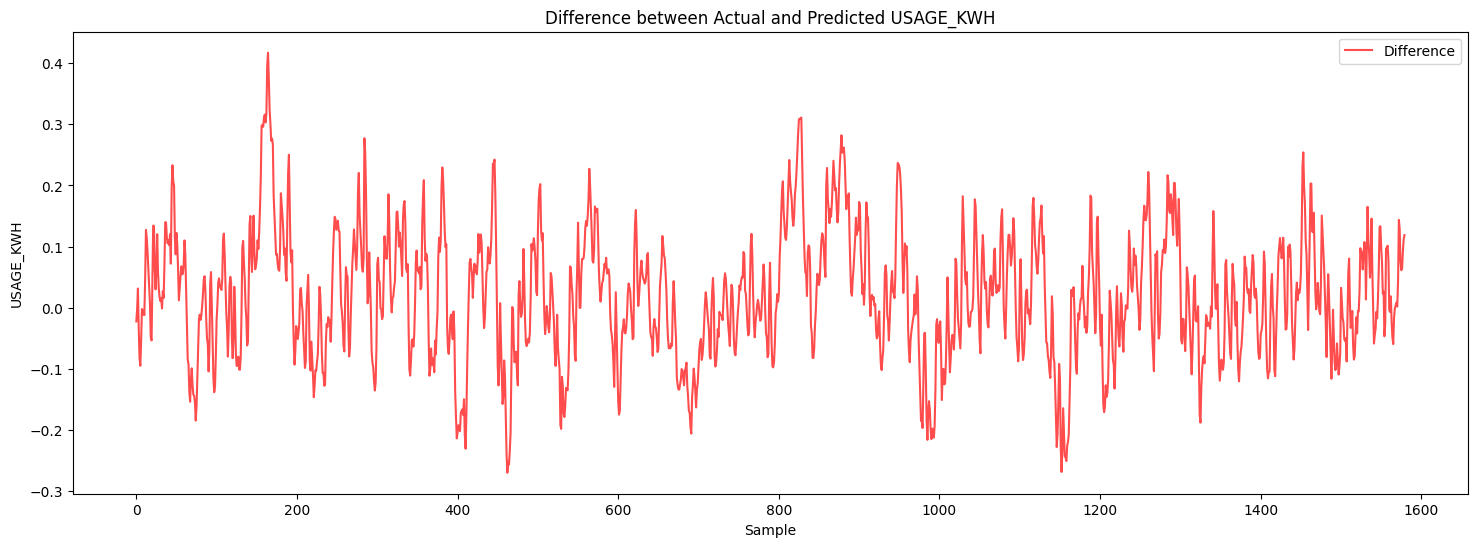

In [11]:
_ = evaluate_model(model, X_val, y_val, scaler_y)